In [1]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium
pip install --upgrade holidays


Executing: /tmp/apt-key-gpghome.diOXQfVmZp/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.2PxtsGdbdu/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.dUEgv4Z7Wu/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 https://cloud.r-project.org/bin/l

In [5]:
# Usaremos la librería selenium y beautiful soup para hacer web scraping
from selenium import webdriver
import datetime
import time
from bs4 import BeautifulSoup
import requests
import pandas as pd
from requests import get
import re
import openpyxl
from datetime import date
from datetime import timedelta
import holidays

#Ubicamos el chromedriver y la página web de donde vamos a scrapear
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.headless = True
driver = webdriver.Chrome(options=chrome_options)
driver.get("https://www.sbs.gob.pe/app/pp/EstadisticasSAEEPortal/Paginas/TIActivaTipoCreditoEmpresa.aspx?tip=B")


#generamos un dataframe vacío que nos servirá más adelante
resultado = pd.DataFrame()
#Insertar los años a consultar
lista_fechas = ['29/01/2021',"05/06/2023","25/05/2023","01/07/2018"]


def DateToStr(Input):
  string = str(Input.day)+"/"+str(Input.month)+"/"+str(Input.year)
  return string

def Consultar_Fecha(Fecha_Input):
    fecha_str = Fecha_Input
    tasas_input = driver.find_element("xpath",'//*[@id="ctl00_cphContent_rdpDate_dateInput"]')
    tasas_input.clear()
    tasas_input.send_keys(fecha_str)
    time.sleep(5)
    buttonConsultar = driver.find_element("xpath",'//*[@id="ctl00_cphContent_btnConsultar"]')
    buttonConsultar.click()
    time.sleep(10)
    soup  = BeautifulSoup(driver.page_source, 'html.parser')
    Advertencia = soup.find_all("span",class_="APLI_fila2")
    return soup, Advertencia, fecha_str

def BuscadorFechas(Lista,Advertencia):
  Nuevas_Fechas = list()
  Advertencia_Local = list()
  for x in Lista:
    print(x)
    fecha = datetime.datetime.strptime(x, '%d/%m/%Y').date()
    fecha_1T = False
    fecha_2T = False
    fecha_util_1 = fecha
    fecha_util_2 = fecha
    print(fecha.day)
    delta = timedelta(days=1)
    contador_adelante = 0
    contador_atras = 0
    pe_holidays = holidays.PE()  # this is a dict
    # the below is the same, but takes a string:
    if fecha in pe_holidays  == True or fecha.weekday() > 5 or len(Advertencia) > 0:
      print("Feriado o fín de semana")
      while fecha_1T == False:
        fecha_util_1 = fecha_util_1 + delta
        contador_adelante = contador_adelante + 1
        if len(Advertencia) or len(Advertencia_Local) > 0 :
          Advertencia_Local = Consultar_Fecha(DateToStr(fecha_util_1))[1]
        if fecha_util_1 in pe_holidays == True or fecha_util_1.weekday() > 5 or len(Advertencia_Local) > 0:
          print("La nueva fecha es un feriado o un fin de semana")
        else:
          fecha_1T = True
          fecha = fecha_util_1
      while fecha_2T == False:
        fecha_util_2 = fecha_util_2-delta
        print(fecha_util_2)
        contador_adelante = contador_atras + 1
        if len(Mensaje_Advertencia) or len(Advertencia_Local) > 0:
            Advertencia_Local = Consultar_Fecha(DateToStr(fecha_util_2))[1]
        if fecha_util_2 in pe_holidays == True or fecha_util_2.weekday() > 5 or len(Advertencia_Local) > 0:
          print("La nueva fecha es un feriado o un fin de semana")
        else:
          fecha_2T = True
      if contador_adelante == contador_atras:
        fecha = fecha_util_2
        print("La Nueva Fecha sera", fecha)
      elif contador_adelante < contador_atras:
        fecha = fecha_util_1
        print("La Nueva Fecha sera", fecha)
      elif contador_atras < contador_adelante:
        fecha = fecha_util_2
        print("La Nueva Fecha sera", fecha)
    else:
      print("No es feriado o fin de semana")
    fecha = str(fecha.day)+"/"+str(fecha.month)+"/"+str(fecha.year)
    print(fecha)
    Nuevas_Fechas.append(fecha)
    print(Nuevas_Fechas)
  return Nuevas_Fechas
Mensaje_Advertencia = list()
Lista_Fechas_Nuevas = BuscadorFechas(lista_fechas,Mensaje_Advertencia)

print("Lista Fechas Nuevas: ", Lista_Fechas_Nuevas)
#Iteramos por cada observación para que cada elemento de la lista ingrese en la fecha a consultar de la
#página web.
for i in Lista_Fechas_Nuevas:
    print("La fecha actual es",i)
    Valores = Consultar_Fecha(i)
    soup = Valores[0]
    Mensaje_Advertencia = Valores[1]
    fecha_str = Valores[2]
    print("Cantidad de Mensaje_Advertencia: ",len(Mensaje_Advertencia))
    if len(Mensaje_Advertencia) > 0:
      for j in Mensaje_Advertencia:
        print("El J es : ",j)
        lista_advertencia = list()
        lista_advertencia.append(fecha_str)
        Nueva_Fecha_En_Caso_Error = BuscadorFechas(lista_advertencia,Mensaje_Advertencia)
        print("La nueva fecha debido a error es: ",Nueva_Fecha_En_Caso_Error[0])
        print("La fecha actual es",i)
        fecha_str = Nueva_Fecha_En_Caso_Error[0]
        tasas_input = driver.find_element("xpath",'//*[@id="ctl00_cphContent_rdpDate_dateInput"]')
        tasas_input.clear()
        tasas_input.send_keys(fecha_str)
        time.sleep(5)
        buttonConsultar = driver.find_element("xpath",'//*[@id="ctl00_cphContent_btnConsultar"]')
        buttonConsultar.click()
        time.sleep(30)
        soup  = BeautifulSoup(driver.page_source, 'html.parser')
    Nombre_Tasas = soup.find_all("td", class_="rpgRowHeaderField rpgRowHeader APLI_fila1_new")
    Lista_Nombre_Tasas = list()
    for p in Nombre_Tasas:
      Lista_Nombre_Tasas.append(p.text)
    Lista_Nombre_Tasas = Lista_Nombre_Tasas[:Lista_Nombre_Tasas.index('   Préstamos hipotecarios para vivienda')+1]
    Tasas_Todas = soup.find_all("td", class_='rpgDataCell APLI_fila2_new')
    Lista_Tasas_Todas = list()
    for v in Tasas_Todas:
      Lista_Tasas_Todas.append(v.text)
    Bancos_Nombres = soup.find_all ("th",class_='rpgColumnHeader APLI_fila2_new APLI_columnaACT_new')
    Lista_Bancos_Nombres = list()
    for z in Bancos_Nombres:
      Lista_Bancos_Nombres.append(z.text)
    Lista_Bancos_Nombres = Lista_Bancos_Nombres[0:Lista_Bancos_Nombres[1:].index("BBVA")+1]
    print("Nombre Tasas:", Lista_Nombre_Tasas)
    print("Tasas Todas", Lista_Tasas_Todas)
    print("Nombre Bancos:",Lista_Bancos_Nombres)
    matriz_1 = {}
    for y in range(0,len(Lista_Bancos_Nombres)):
      columna = list()
      for z in range(0,len(Lista_Nombre_Tasas)):
        columna.append(Lista_Tasas_Todas[(y)+(z)*(len(Lista_Bancos_Nombres))])
        matriz_1[Lista_Bancos_Nombres[y]] = columna
    print(matriz_1)
    df = pd.DataFrame(matriz_1)
    df.index = Lista_Nombre_Tasas
    Nombre_Fecha = fecha_str
    Nombre_Fecha = Nombre_Fecha.replace("/","-")+".xlsx"
    df.to_excel(Nombre_Fecha)
    Nombre_Captura = fecha_str
    Nombre_Captura = Nombre_Captura.replace("/","-")+".png"
    driver.set_window_size(1920, 1600)
    driver.save_screenshot(Nombre_Captura)



29/01/2021
29
No es feriado o fin de semana
29/1/2021
['29/1/2021']
05/06/2023
5
No es feriado o fin de semana
5/6/2023
['29/1/2021', '5/6/2023']
25/05/2023
25
No es feriado o fin de semana
25/5/2023
['29/1/2021', '5/6/2023', '25/5/2023']
01/07/2018
1
Feriado o fín de semana
2018-06-30
La Nueva Fecha sera 2018-06-30
30/6/2018
['29/1/2021', '5/6/2023', '25/5/2023', '30/6/2018']
Lista Fechas Nuevas:  ['29/1/2021', '5/6/2023', '25/5/2023', '30/6/2018']
La fecha actual es 29/1/2021
Cantidad de Mensaje_Advertencia:  0
Nombre Tasas: ['         Corporativos', '   Descuentos', '   Préstamos hasta 30 días', '   Préstamos de 31 a 90 días', '   Préstamos de 91 a 180 días', '   Préstamos de 181 a 360 días', '   Préstamos a más de 360 días', '         Grandes Empresas', '   Descuentos', '   Préstamos hasta 30 días', '   Préstamos de 31 a 90 días', '   Préstamos de 91 a 180 días', '   Préstamos de 181 a 360 días', '   Préstamos a más de 360 días', '         Medianas Empresas', '   Descuentos', '   P

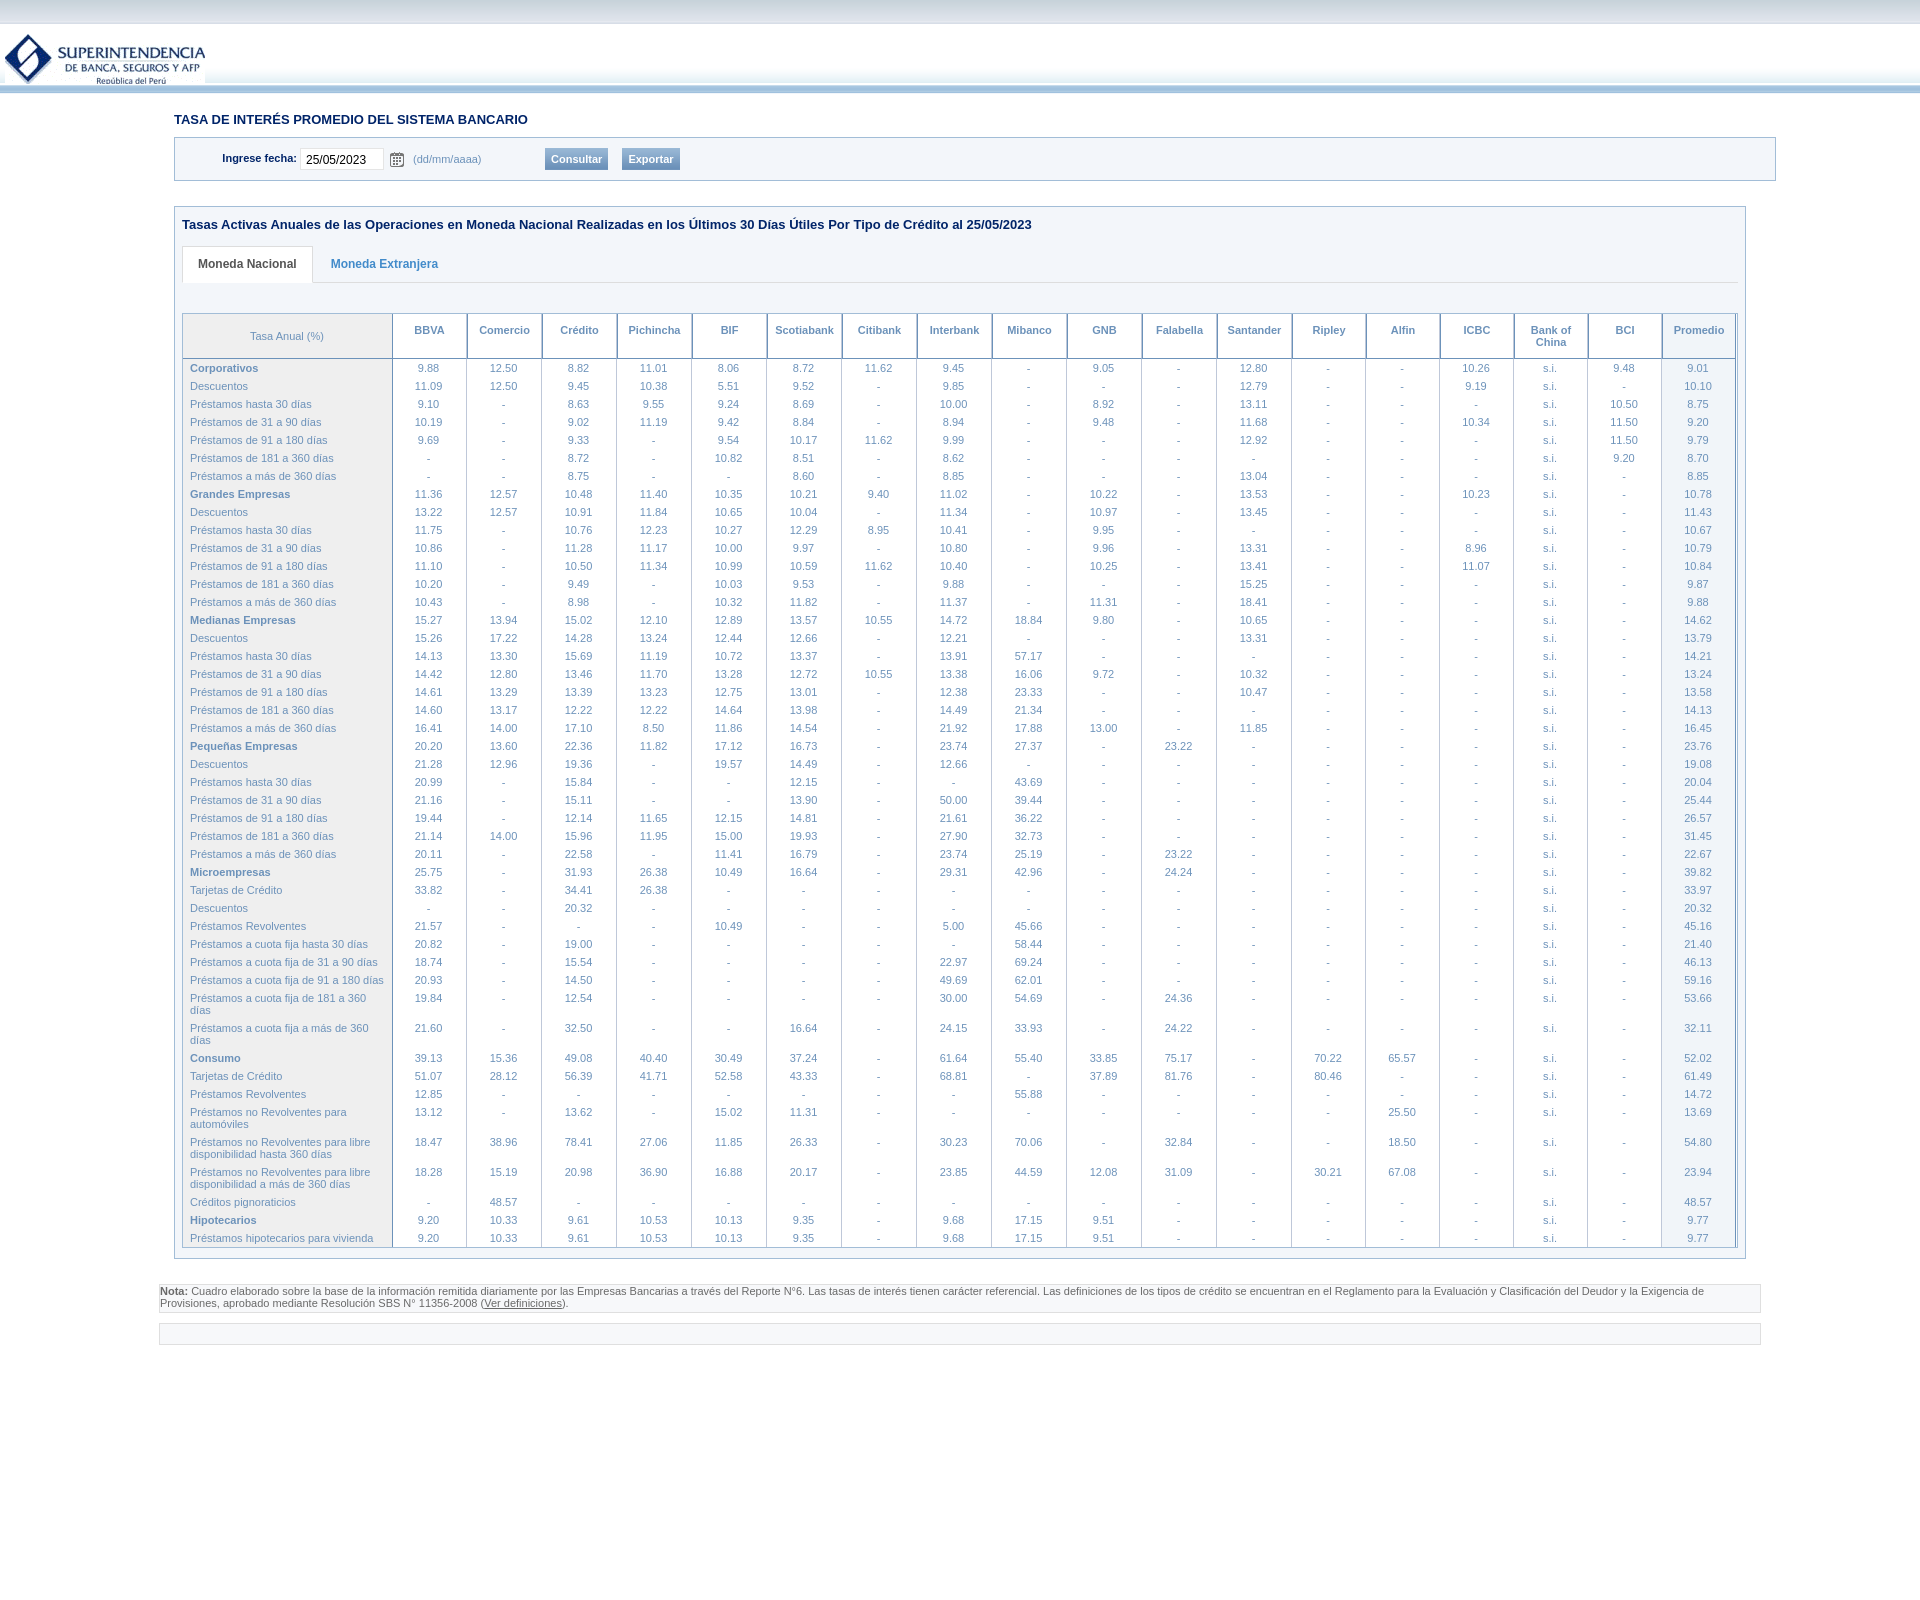

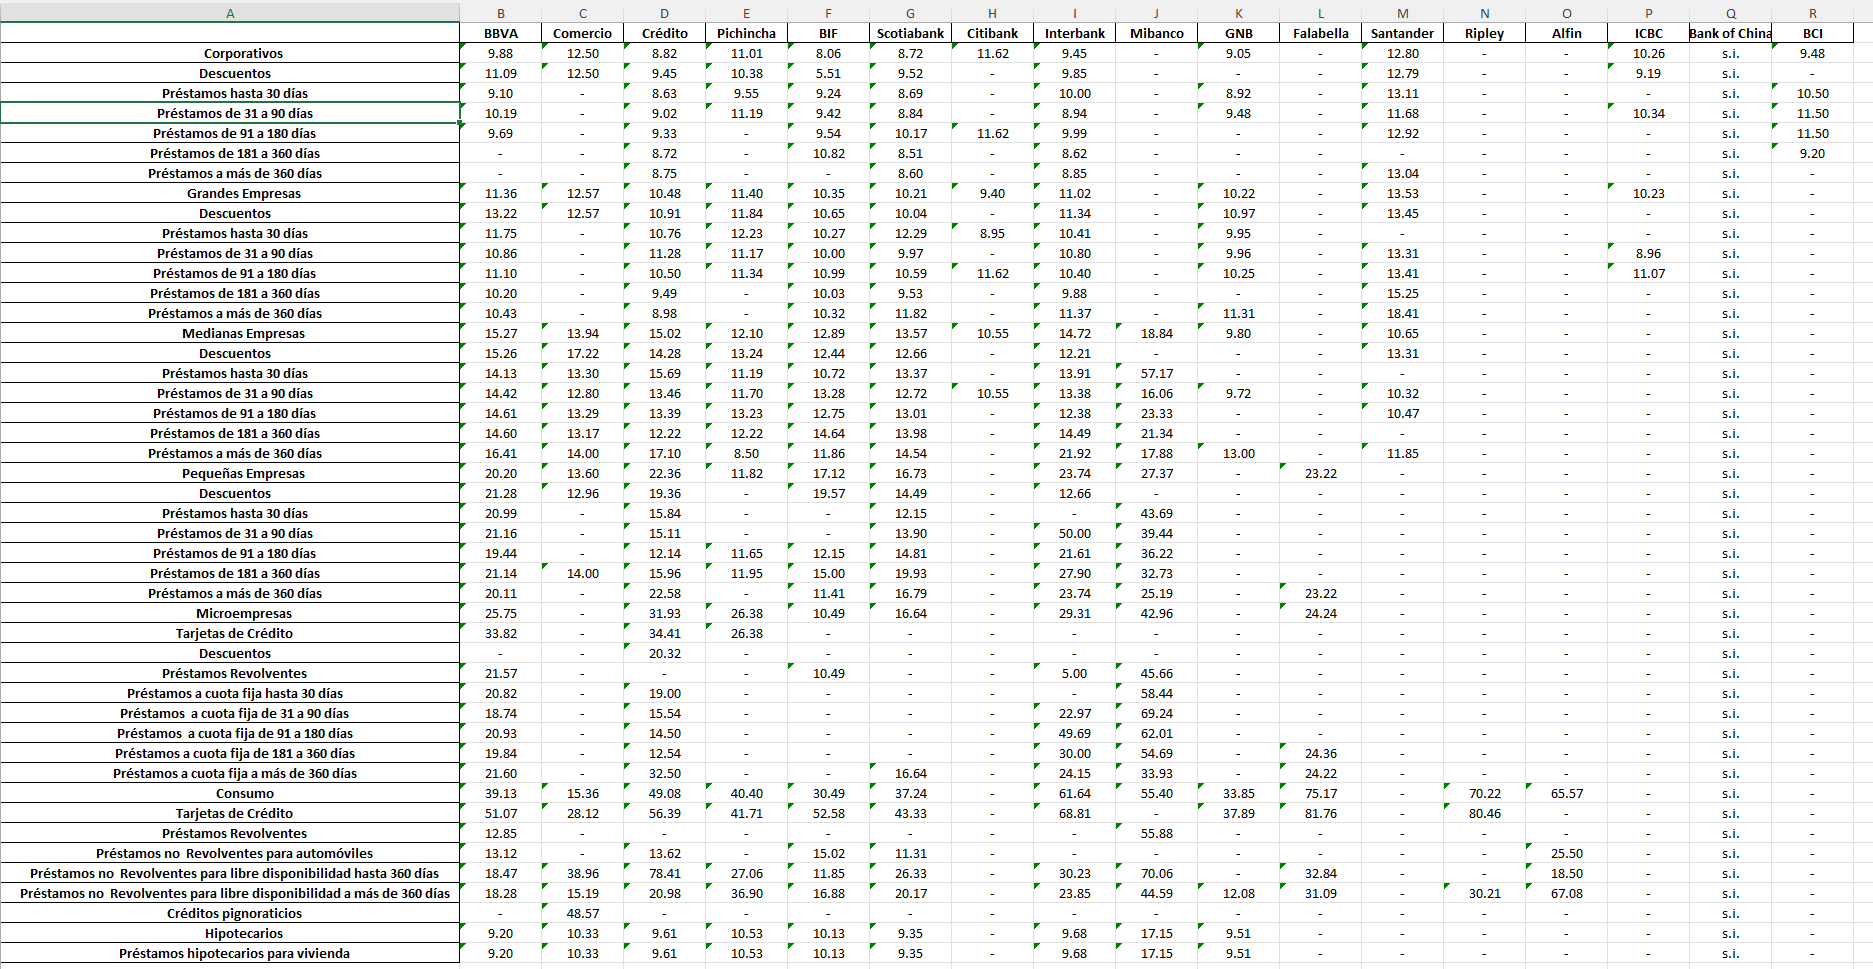